In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.table import Table
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from arch import arch_model

from scipy.interpolate import BSpline, make_interp_spline
from scipy.interpolate import splrep, splev
from lmfit import Model, Parameters
from statsmodels.tsa.stattools import acf


In [2]:
from lmfit import Model, Parameters
import numpy as np


layer = 50

import numpy as np

def harmonic_func(t, beta_0, m, **kwargs):
    # Extract alpha, phi, eta, gamma, and delta values from kwargs
    alphas = [kwargs[f'alpha_{i}'] for i in range(layer)]
    phis = [kwargs[f'phi_{i}'] for i in range(layer)]
    etas = [kwargs[f'eta_{i}'] for i in range(layer)]
    gammas = [kwargs.get(f'gamma_{i}', 0) for i in range(layer)]
    deltas = [kwargs.get(f'delta_{i}', 0) for i in range(layer)]

    # Initial term
    y = alphas[0] * beta_0 + beta_0 * np.sin(2 * np.pi * t / m + phis[0])

    # Add the harmonic terms
    for i in range(1, layer):
        # Since we're not using the 'complex' version, we can ignore 'modified_phi_i'
        y += (alphas[0] * alphas[i] + alphas[i] * np.sin(2 * np.pi * i * t / m + phis[i])) \
             * np.sin(2 * np.pi * i * t / m + etas[i])
    return y



def harmonic_func_closure():
    def harmonic_func(t, beta_0, m, **kwargs):
        # Extract alpha, phi, eta, gamma, and delta values from kwargs
        alphas = [kwargs[f'alpha_{i}'] for i in range(layer)]
        phis = [kwargs[f'phi_{i}'] for i in range(layer)]
        etas = [kwargs[f'eta_{i}'] for i in range(layer)]
        gammas = [kwargs.get(f'gamma_{i}', 0) for i in range(layer)]
        deltas = [kwargs.get(f'delta_{i}', 0) for i in range(layer)]

        # Initial term
        y = alphas[0] * beta_0 + beta_0 * np.sin(2 * np.pi * t / m + phis[0])

        # Add the harmonic terms
        for i in range(1, layer):
            # Since we're not using the 'complex' version, we can ignore 'modified_phi_i'
            y += (alphas[0] * alphas[i] + alphas[i] * np.sin(2 * np.pi * i * t / m + phis[i])) \
                 * np.sin(2 * np.pi * i * t / m + etas[i])
        return y
    return harmonic_func





In [3]:
from numba import jit
import numpy as np

def MAD_2(x):
    n = len(x)
    pairwise_diffs = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            pairwise_diffs[i, j] = np.abs(x[i] - x[j])
    
    med_of_meds = np.median([np.median(pairwise_diffs[i, :]) for i in range(n)])
    Sn_value = 1.1926 * med_of_meds
    return Sn_value




@jit(nopython=True)
def MAD_1(x):
    n = len(x)
    MAD = np.zeros(n)
    median_x = np.median(x)
    for j in range(n):                
        MAD[j] = abs(x[j] - median_x)
    sigma_hat = 1.4826 * np.median(MAD)
    return sigma_hat



def replace_with_none(Y, i, t, radius):
    for offset in range(-radius, radius + 1):
        pos = t + offset
        if 0 <= pos < len(Y[i+1, :]):
            Y[i+1, pos] = None
            
def delete_positions(Y, i, t, before, after):
    # Delete positions before the point
    for offset in range(1, before + 1):
        pos = t - offset
        if pos >= 0:
            Y[i+1, pos] = None
    # Delete positions after the point
    for offset in range(1, after + 1):
        pos = t + offset
        if pos < len(Y[i+1, :]):
            Y[i+1, pos] = None


def fill_nan_with_linear_interpolation(series):
    filled_series = np.copy(series)
    nans, x = np.isnan(series), lambda z: z.nonzero()[0]
    filled_series[nans] = np.interp(x(nans), x(~nans), series[~nans])
    return filled_series


def params_converged(params_old, params_new, threshold=0.0001):
    # Calculate the L2 norm of the difference between old and new parameters
    squared_diffs = sum((params_old[key].value - params_new[key].value) ** 2 for key in params_old)
    l2_norm = np.sqrt(squared_diffs)
    
    return l2_norm < threshold





In [4]:
import numpy as np
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf

def flare_detection_MAD(time, y, alpha=0.99, n=4, N=100, radius=4):
    model = Model(harmonic_func)
    I = n  # Number of iterations
    Y = np.zeros((I + 1, len(y)))
    X = np.zeros((I + 1, len(y)))
    Z = np.zeros((I + 1, len(y)))
    Test_stats = np.zeros((I + 1, len(y)))
    PI = np.zeros((I + 1, len(y)))
    alpha_values = [alpha]

    # Distribution for calculating thresholds
    dist = stats.halfnorm(scale=1)
    q = dist.ppf(alpha)

    # Initial assignment
    Y[0, :] = y

    # Fit initial harmonic model to Y[0, :]
    result = model.fit(y, params, t=time)
    mu_0 = result.best_fit  # mu^(0)
    X[0, :] = Y[0, :] - mu_0  
    params_old = None
    
    lags = 10
    acf_values = acf(X[0,:], nlags=lags)


    # Determine significant lags
    ts = 1.96 / np.sqrt(len(X[0,:]))
    significant_lags = np.where(np.abs(acf_values) > ts)[0]

    for i in range(I):
        if params_old is not None and params_converged(params_old, result.params):
            print("Convergence achieved.")
            break
        params_old = result.params
        
        # Fit ARMA(1,1) to X[i, :] to get Z[i, :]
        arma_model = ARIMA(X[i, :], order=(1, 0, 1))
        arma_result = arma_model.fit()
        Z[i, :] = arma_result.resid

        # Compute test statistics and PI values
        for t in range(len(Z[i, :])):
            # Compute scale estimator S_t^(i)
            if t < N:
                S = MAD_1(Z[i, :N])
            else:
                S = MAD_1(Z[i, :t - 1])
            test_stat = abs(Z[i, t]) / S
            Test_stats[i, t] = test_stat
            PI[i, t] = dist.sf(test_stat)  # Survival function (1 - CDF)

            # Detect outliers based on PI and update Y[i + 1, :]
            if test_stat > q and X[i, t]>0:
                Y[i+1, t] = None
                delete_positions(Y, i, t, before = 0, after = significant_lags[-1])
            else:
                Y[i + 1, t] = Y[i, t]

        # Fill NaNs in Y[i + 1, :] for fitting mu^(i+1)
        ts_object = fill_nan_with_linear_interpolation(Y[i + 1, :].copy())
        # Fit harmonic model to Y[i + 1, :]
        result = model.fit(ts_object, params_old, t=time)
        mu_i1 = result.best_fit  # mu^(i+1)
        X[i + 1, :] = ts_object - mu_i1  # X^(i+1)

        # Update alpha^(i+1)
        temp_alpha = PI[i, (PI[i, :] < alpha_values[i]) & (PI[i, :] > 0)]
        if len(temp_alpha) > 0:
            alpha_values.append(np.max(temp_alpha))
            alpha = alpha_values[-1]
            q = dist.ppf(alpha)
        else:
            alpha_values.append(alpha_values[i])

    # Calculate the final harmonic residuals
    harmonic_residuals = Y[0, :] - mu_i1
    best_fit = mu_i1

    return harmonic_residuals, best_fit, model, params_old


In [5]:
def pdcsap_flux_to_mjy(pdcsap_flux):
    """
    Convert PDCSAP_FLUX from electrons per second (e-/s) to milliJanskys (mJy).

    Parameters:
    -----------
    pdcsap_flux : float or array-like
        PDCSAP_FLUX values in electrons per second (e-/s).

    Returns:
    --------
    flux_mJy : float or ndarray
        Flux values in milliJanskys (mJy).
    """
    # Ensure input is a NumPy array for vectorized operations
    r = np.asarray(pdcsap_flux)
    
    # Validate that all count rates are positive
    if np.any(r <= 0):
        raise ValueError("All PDCSAP_FLUX values must be positive and non-zero.")
    
    # Step 1: Convert count rate to TESS magnitude
    m_T = -2.5 * np.log10(r) + 20.44
    
    # Step 2: Convert TESS magnitude to flux in mJy
    flux_mJy = 2.416e6 * 10**(-0.4 * m_T)
    
    return flux_mJy

In [6]:
import os

file_path = 'TIC269797536/hlsp_tess-spoc_tess_phot_0000000269797536-s0038_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000269797536-s0038_tess_v1_lc.fits'


directory = os.path.dirname(file_path)
base_name = os.path.basename(file_path)
first_element = file_path.split('/')[0]  # "TIC269797536"
second_element = base_name.split('_')[3].split('-')[0]  # "s0005"

In [7]:
# Open the FITS file
with fits.open(file_path) as hdul:
    # Access the data in the LIGHTCURVE extension (hdul[1])
    lightcurve_data = hdul[1].data
    summary_data = hdul[0].data
    # Convert the data to an Astropy Table
    lightcurve_table = Table(lightcurve_data)
    summary_table = Table(summary_data)
    # Convert the Astropy Table to a pandas DataFrame
    lightcurve_df = lightcurve_table.to_pandas()
    summary_df = summary_table.to_pandas()
    # Print the first few rows of the DataFrame

import numpy as np
# Select the desired columns
LC_FLUX = lightcurve_df[['TIME', 'PDCSAP_FLUX', 'PDCSAP_FLUX_ERR']]
LC_FLUX_mod = LC_FLUX


nan_mask = LC_FLUX['PDCSAP_FLUX'].isna()

# Get the indices of NaN values
nan_indices = LC_FLUX.index[nan_mask]



if len(nan_indices) == 0:
    print("No -1 values found in the 'DE-HARMONIC' column.")
else:
    # Find the differences between successive indices
    diffs = np.diff(nan_indices)

    # Identify where the difference is greater than 1 (non-consecutive indices)
    split_points = np.where(diffs > 1)[0]

    # Add start and end points for indexing
    split_points = np.concatenate(([0], split_points + 1, [len(nan_indices)]))

    # Extract start and end indices for consecutive -1 sequences
    consecutive_nan_ranges = [(nan_indices[start], nan_indices[end - 1])
                                    for start, end in zip(split_points[:-1], split_points[1:])]

    print("Start and end indices of consecutive NaN values:", consecutive_nan_ranges)


max_difference = -1
max_tuple = None

for tup in consecutive_nan_ranges:
    diff = tup[1] - tup[0]  
    if diff > max_difference:
        max_difference = diff
        max_tuple = tup

first_number, last_number = max_tuple
print(f"The tuple with the largest difference is: {max_tuple}")
print(f"The first number is: {first_number}, and the last number is: {last_number}")

Start and end indices of consecutive NaN values: [(0, 62), (886, 889), (1763, 1765), (1797, 1935), (2875, 2878), (3651, 3651)]
The tuple with the largest difference is: (1797, 1935)
The first number is: 1797, and the last number is: 1935


In [8]:
start_index = first_number
end_index = last_number

#start_index = 1706
#end_index = 1853

In [9]:
# Step 1: Identify non-NaN values
is_not_nan = ~LC_FLUX_mod['PDCSAP_FLUX'].isna()

# Step 2: Find the index of the first non-NaN value
start = is_not_nan.idxmax()

# Step 3: Reverse the series to find the index of the last non-NaN value
end = is_not_nan[::-1].idxmax()

start, end

(63, 3843)

In [10]:
t1 = LC_FLUX_mod['TIME'].values[start:start_index]  
y1 = LC_FLUX_mod['PDCSAP_FLUX'].fillna(method='ffill').fillna(method='bfill').values[start:start_index]
t2 = LC_FLUX_mod['TIME'].values[end_index+1:end] 
y2 = LC_FLUX_mod['PDCSAP_FLUX'].fillna(method='ffill').fillna(method='bfill').values[end_index+1:end]


from scipy.interpolate import interp1d

# Find indices of missing values
missing_indices = np.isnan(t1)

# Create interpolation function
interpolate_fn = interp1d(np.where(~missing_indices)[0], t1[~missing_indices], kind='linear', fill_value='extrapolate')

# Interpolate missing values
t1 = t1.copy()
t1[missing_indices] = interpolate_fn(np.where(missing_indices)[0])

print("Missing values in t1 after interpolation:", np.isnan(t1).any())



Missing values in t1 after interpolation: False


C:\Users\wqy21\AppData\Local\Temp\ipykernel_39188\871014953.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y1 = LC_FLUX_mod['PDCSAP_FLUX'].fillna(method='ffill').fillna(method='bfill').values[start:start_index]
C:\Users\wqy21\AppData\Local\Temp\ipykernel_39188\871014953.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y2 = LC_FLUX_mod['PDCSAP_FLUX'].fillna(method='ffill').fillna(method='bfill').values[end_index+1:end]


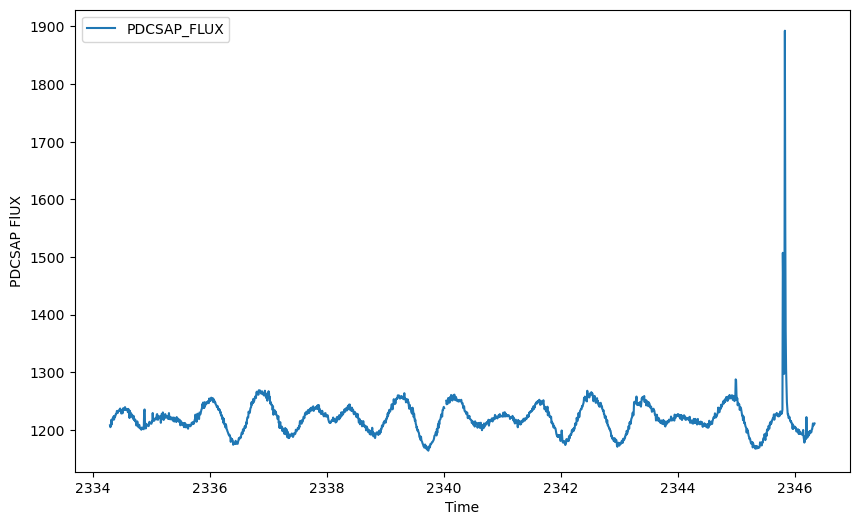

In [11]:
plt.figure(figsize=(10, 6))
part1 = LC_FLUX.iloc[start:start_index]
plt.plot(part1['TIME'], part1['PDCSAP_FLUX'], label='PDCSAP_FLUX')
plt.xlabel('Time')
plt.ylabel('PDCSAP FlUX')
plt.legend()
plt.show()

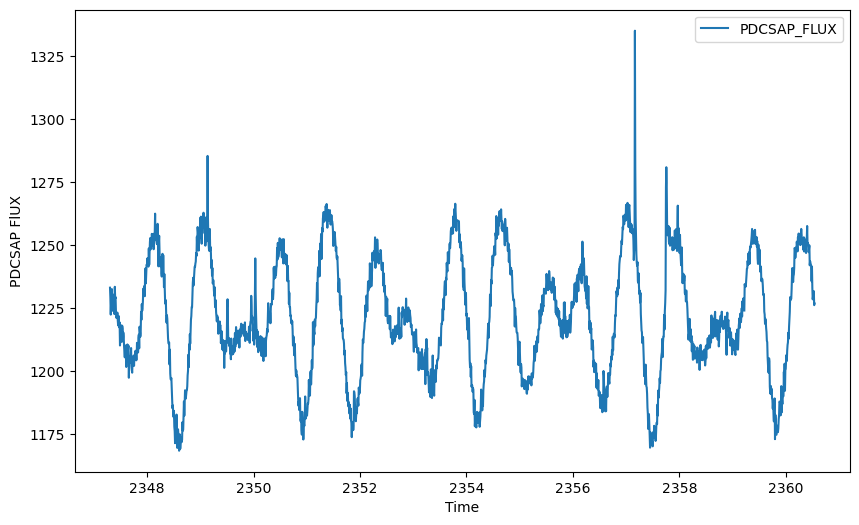

In [12]:
plt.figure(figsize=(10, 6))
part2 = LC_FLUX.iloc[end_index+1:end]
plt.plot(part2['TIME'], part2['PDCSAP_FLUX'], label='PDCSAP_FLUX')
plt.xlabel('Time')
plt.ylabel('PDCSAP FlUX')
plt.legend()

plt.savefig('TIC269797536/hlsp_tess-spoc_tess_phot_0000000269797536-s0005_tess_v1_tp/Part_2_Step_1.pdf')
plt.show()

In [13]:
ERROR = LC_FLUX['PDCSAP_FLUX_ERR']
ERROR = ERROR.fillna(0)

In [14]:
layer = 40

# Create a harmonic function closure (assuming it's defined elsewhere)
# model = Model(harmonic_func_closure(complex=False))

# Create parameters, setting initial values
params = Parameters()
params.add('beta_0', value=50)
params.add('m', value=15)

# Add alpha, phi, gamma, and delta parameters
for i in range(layer):  # alpha_0 to alpha_39 and phi_0 to phi_39
    params.add(f'alpha_{i}', value=5)
    params.add(f'phi_{i}', value=3)
    params.add(f'eta_{i}', value=1)
    params.add(f'gamma_{i}', value=0.1, vary=True)  
    params.add(f'delta_{i}', value=0, vary=True)  

max_iter = 3

# Call the modified flare_detection_MAD function
harmonic_residuals_1, best_fit_1, model_1, params_1 = flare_detection_MAD(time=t1, y=y1.copy(), alpha=0.99, n=max_iter, N=100, radius=4)

final_result_1 = model_1.fit(y1.copy(), params_1, t = t1)





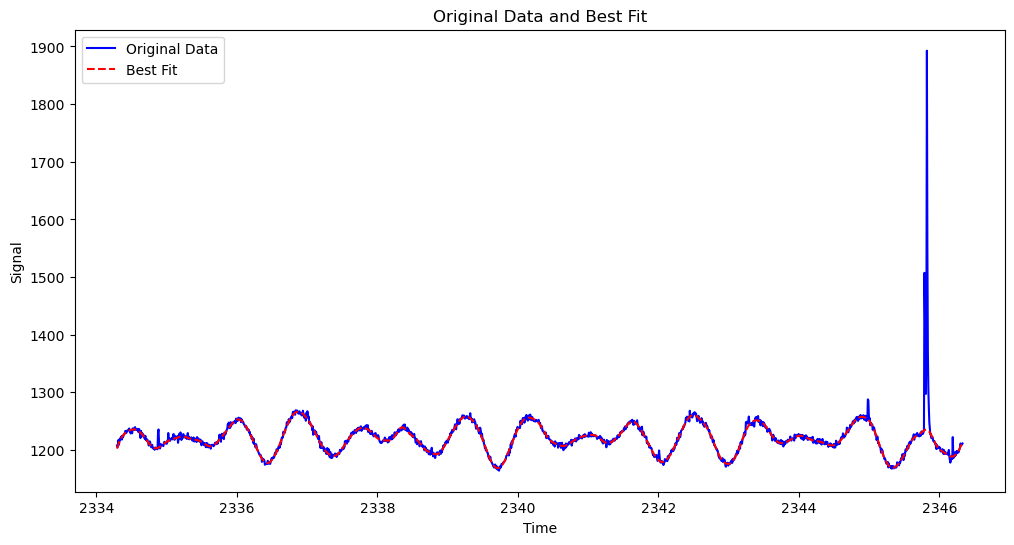

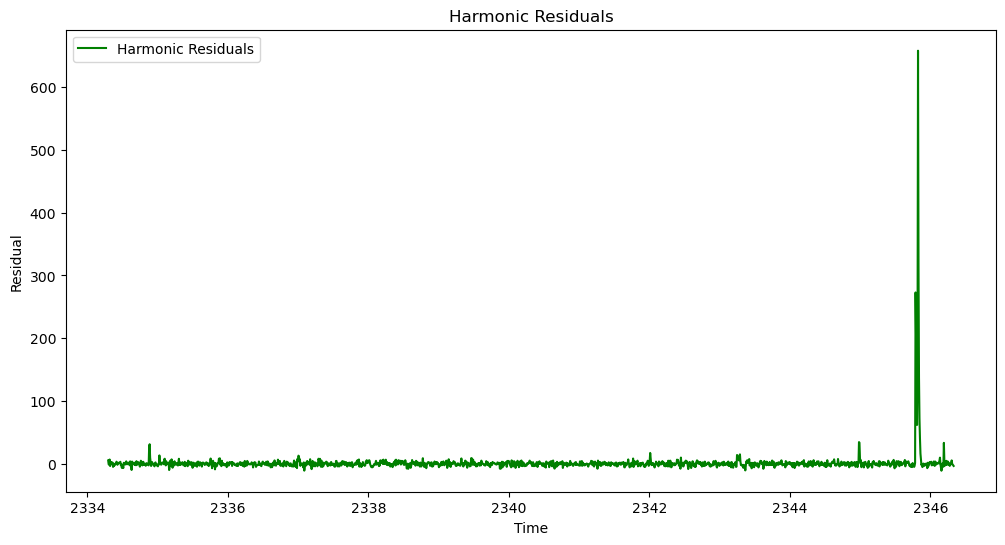

In [15]:
# Plotting the original curve with the best fit
plt.figure(figsize=(12, 6))
plt.plot(t1, y1, label='Original Data', color='blue')
plt.plot(t1, best_fit_1, label='Best Fit', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Original Data and Best Fit')
plt.legend()
plt.show()

# Plotting the harmonic residuals
plt.figure(figsize=(12, 6))
plt.plot(t1, harmonic_residuals_1, label='Harmonic Residuals', color='green')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Harmonic Residuals')
plt.legend()
plt.show()

In [16]:
layer = 40

# Create a harmonic function closure (assuming it's defined elsewhere)
# model = Model(harmonic_func_closure(complex=False))

# Create parameters, setting initial values
params = Parameters()
params.add('beta_0', value=50)
params.add('m', value=15)

# Add alpha, phi, gamma, and delta parameters
for i in range(layer):  # alpha_0 to alpha_39 and phi_0 to phi_39
    params.add(f'alpha_{i}', value=5)
    params.add(f'phi_{i}', value=3)
    params.add(f'eta_{i}', value=1)
    params.add(f'gamma_{i}', value=0.1, vary=True)  
    params.add(f'delta_{i}', value=0, vary=True)  

max_iter = 3

# Call the modified flare_detection_MAD function
harmonic_residuals_2, best_fit_2,model_2,  params_2= flare_detection_MAD(time=t2, y=y2.copy(), alpha=0.99, n=max_iter, N=100, radius=4)

final_result_2 = model_2.fit(y2.copy(), params_2, t = t2)

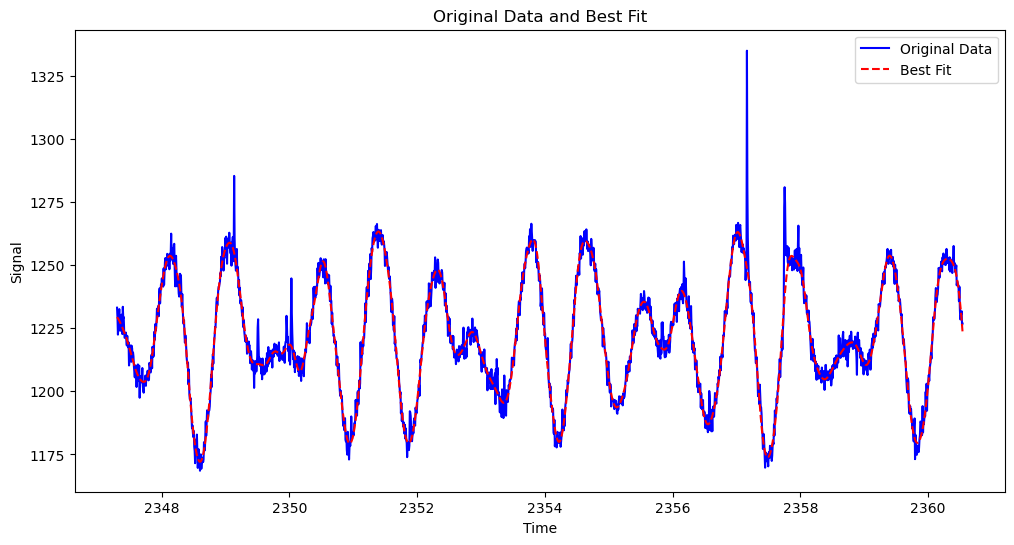

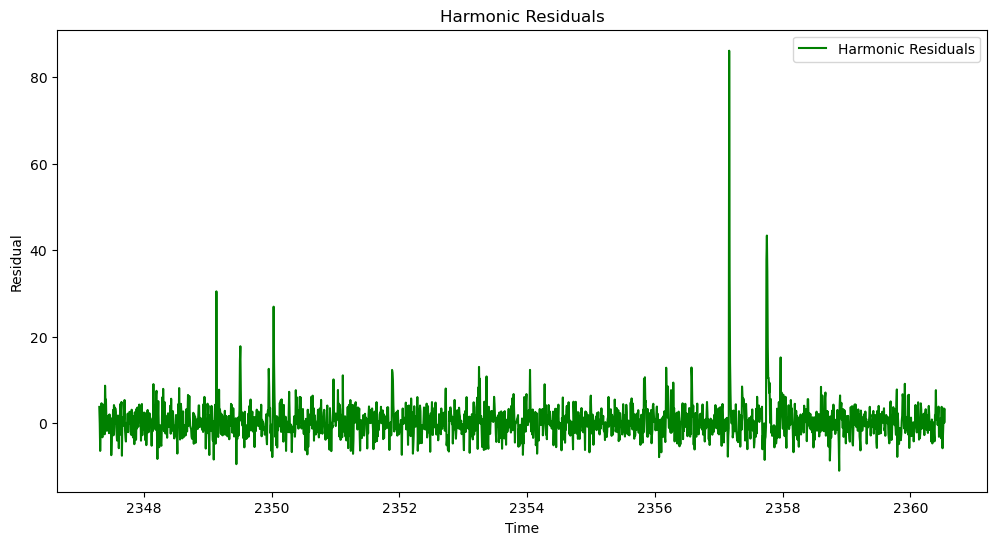

In [17]:
# Plotting the original curve with the best fit
plt.figure(figsize=(12, 6))
plt.plot(t2, y2, label='Original Data', color='blue')
plt.plot(t2, best_fit_2, label='Best Fit', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Original Data and Best Fit')
plt.legend()
plt.show()

# Plotting the harmonic residuals
plt.figure(figsize=(12, 6))
plt.plot(t2, harmonic_residuals_2, label='Harmonic Residuals', color='green')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Harmonic Residuals')
plt.legend()
plt.show()

In [18]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings

# Suppress warnings for better readability
warnings.filterwarnings("ignore")

# Step 1: Fit ARMA models and find the best model using BIC
best_bic_1 = np.inf
best_order_1 = None
best_model_1 = None

for p in range(1, 3):
    for q in range(1, 3):
        try:
            # Fit ARMA(p, q)
            arma_model_1 = ARIMA(harmonic_residuals_1, order=(p, 0, q))
            arma_result_1 = arma_model_1.fit()
            # Compare BIC
            if arma_result_1.bic < best_bic_1:
                best_bic_1 = arma_result_1.bic
                best_order_1 = (p, q)
                best_model_1 = arma_result_1
        except Exception as e:
            # Ignore models that fail to converge
            continue

print(f"Best ARMA(p, q) model order: {best_order_1} with BIC: {best_bic_1}")

# Step 2: Fit the best ARMA model
if best_model_1 is not None:
    Z1 = best_model_1.resid

Best ARMA(p, q) model order: (1, 2) with BIC: 14459.763513032478


In [19]:
import numpy as np
import pandas as pd
from arch import arch_model

best_bic = np.inf
best_p_1 = None
best_q_1 = None
best_model = None

for p in range(1, 4):
    for q in range(1, 4):
        try:
            # Fit GARCH(p, q) model
            garch_model = arch_model(Z1, vol='Garch', p=p, q=q)
            garch_result = garch_model.fit(disp='off')
            
            # Compare the BIC of the current model with the best BIC so far
            if garch_result.bic < best_bic:
                best_bic = garch_result.bic
                best_p_1 = p
                best_q_1 = q
                best_model = garch_result
        except Exception as e:
            # In case of fitting issues, print the error message and continue
            print(f"Error fitting GARCH({p},{q}) model: {e}")
            continue

# Output the best model and BIC
print(f"Best GARCH model: GARCH({best_p_1},{best_q_1})")
print(f"Best BIC: {best_bic}")

# Extract the conditional volatility from the best model
conditional_volatility_1 = best_model.conditional_volatility

# Assuming residuals are the raw data y1, standardize to obtain epsilon
epsilon_1 = Z1 / conditional_volatility_1

Best GARCH model: GARCH(3,2)
Best BIC: 11650.897777825727


In [20]:
import numpy as np
from scipy.special import erf

def flare_detection(epsilont, alphathr):
    """
    Detects flares in the given epsilon_t array using statistical methods.
    
    Parameters:
    epsilont : numpy.ndarray
        Array of epsilon_t values.
    alphathr : float
        Significance level threshold (alpha).
    
    Returns:
    dict
        Dictionary containing tsig, p-values, and indices of rejections for BH and Holm methods.
    """
    # Step 1: Select valid negative epsilont
    o0 = np.where((epsilont <= 0) & (epsilont != -1))[0]  # Indices where epsilont <= 0 and epsilont != -1
    mo0 = len(o0)  # Number of valid negative epsilont values

    if mo0 == 0:
        raise ValueError("No valid negative epsilont values found (epsilont <= 0 and epsilont != -1).")

    # Step 2: Compute tsig (standard deviation extrapolated from epsilont < 0 by reflecting it)
    tmp = np.concatenate([epsilont[o0], -epsilont[o0]])  # Reflect negative epsilont values
    tsig = np.std(tmp, ddof=1)  # Compute standard deviation

    # Step 3: Fit a normal distribution to tmp and compute the upper quantile
    mu, sigma = norm.fit(tmp)  # Fit normal distribution to tmp
    upper_quantile = norm.ppf(1 - alphathr, loc=mu, scale=sigma)  # 1 - alpha threshold

    # Step 4: Identify candidate flares (indices where epsilont > upper quantile)
    ofl1 = np.where(epsilont > upper_quantile)[0]
    mofl1 = len(ofl1)  # Number of candidate flares

    if mofl1 == 0:
        # No candidate flares found; return empty results
        return {
            'tsig': tsig,
            'p_values': np.array([]),
            'BH_pBH': None,
            'BH_rejections_indices': np.array([], dtype=int),
            'HB_pHB': None,
            'HB_rejections_indices': np.array([], dtype=int)
        }

    # Step 5: Compute p-values based on epsilont width
    tmp1 = epsilont[ofl1]
    pp_raw = 1.0 - erf((tmp1 / tsig) / np.sqrt(2.0))
    pp = np.maximum(pp_raw, alphathr / (mofl1 * 2.0))  # Ensure p-values are not too small

    # Step 6: Index list of candidate flares
    ip = np.arange(mofl1)  # Index list

    # Step 7: Sort p-values
    os = np.argsort(pp)  # Indices that would sort pp
    spp = pp[os]  # Sorted p-values
    sii = np.arange(1, mofl1 + 1)  # Sequence from 1 to mofl1
    sip = ip[os]  # Sorted indices of candidate flares

    # Step 8: Compute thresholds for BH and Holm methods
    BHthr = alphathr * sii / float(mofl1)  # Benjamini-Hochberg FDR threshold
    HBthr = alphathr / (mofl1 - sii + 1.0)  # Holm-Bonferroni FWER threshold

    # Step 9: Benjamini-Hochberg FDR
    kBH = -1
    for i in range(mofl1 - 1, -1, -1):
        if spp[i] <= BHthr[i]:
            kBH = i
            break
    if kBH >= 0:
        pBH = spp[kBH]
        bh_rejections = sip[:kBH + 1]  # Indices of rejections
    else:
        pBH = spp.min() / 10.0
        bh_rejections = np.array([], dtype=int)

    # Step 10: Holm-Bonferroni FWER
    kHB = -1
    for i in range(mofl1):
        if spp[i] > HBthr[i]:
            kHB = i
            break
    if kHB > 0:
        pHB = spp[kHB]
        hb_rejections = sip[:kHB]
    elif kHB == 0:
        pHB = spp[0]
        hb_rejections = np.array([], dtype=int)
    else:
        pHB = spp.min() / 10.0
        hb_rejections = sip  # All hypotheses rejected

    # Map rejections back to original indices in epsilont
    bh_rejections_indices = ofl1[bh_rejections]
    hb_rejections_indices = ofl1[hb_rejections]

    # Return results
    return {
        'tsig': tsig,
        'p_values': pp,
        'BH_pBH': pBH,
        'BH_rejections_indices': bh_rejections_indices,
        'HB_pHB': pHB,
        'HB_rejections_indices': hb_rejections_indices,
        'ofl1':ofl1
    }


In [21]:
from scipy.stats import norm, pareto

alpha = 0.05


flare_results_1 = flare_detection(epsilon_1, alpha)

# Save individual results to the specified variable names
tsig_1 = flare_results_1['tsig']                      # Standard deviation
pp_1 = flare_results_1['p_values']                    # p-values
pBH_1 = flare_results_1['BH_pBH']                     # BH p-value threshold
BHindex1 = flare_results_1['BH_rejections_indices']   # Indices of BH rejections
pHB_1 = flare_results_1['HB_pHB']                     # Holm-Bonferroni p-value threshold
HBindex1 = flare_results_1['HB_rejections_indices']   # Indices of Holm-Bonferroni rejections
ofl1 = flare_results_1['ofl1']

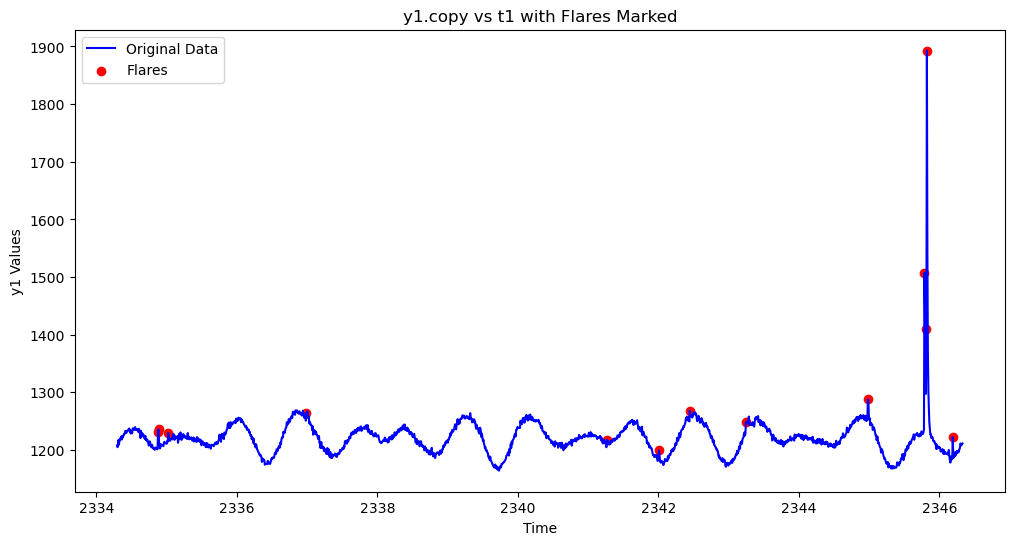

In [22]:



# Plot y1.copy vs t1
plt.figure(figsize=(12, 6))
plt.plot(t1, y1.copy(), label="Original Data", color='blue')

# Plot the flares as red scatter points
plt.scatter(t1[BHindex1], y1.copy()[BHindex1], color='red', label="Flares", marker='o')

# Labeling the plot
plt.xlabel("Time")
plt.ylabel("y1 Values")
plt.title("y1.copy vs t1 with Flares Marked")
plt.legend()

# Show the plot
plt.show()

Best ARMA(p, q) model order: (1, 1) with BIC: 10783.83443937993
Best GARCH model: GARCH(3,1)
Best BIC: 10448.040154103723


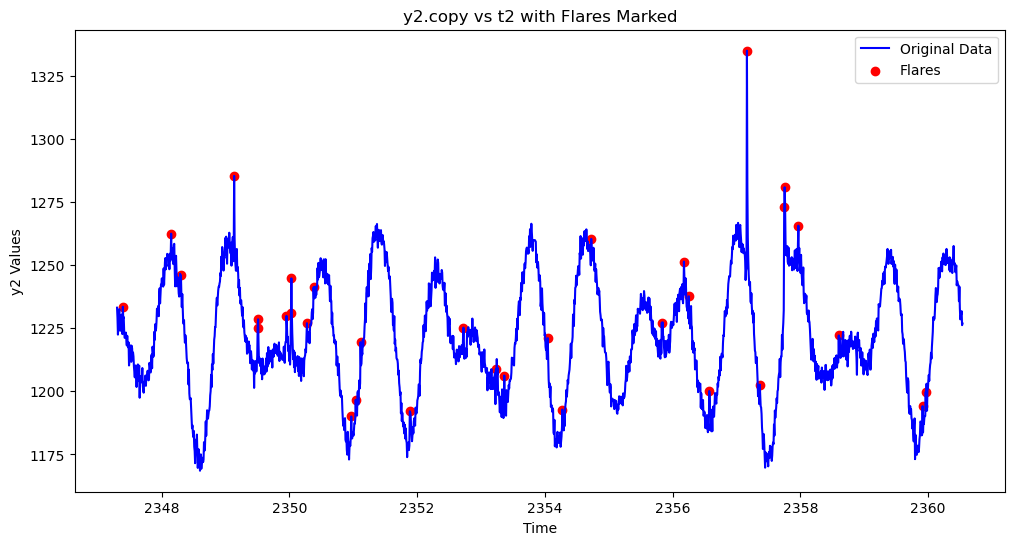

In [23]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings

# Suppress warnings for better readability
warnings.filterwarnings("ignore")

# Step 1: Fit ARMA models and find the best model using BIC
best_bic_2 = np.inf
best_order_2 = None
best_model_2 = None

for p in range(1, 3):
    for q in range(1, 3):
        try:
            # Fit ARMA(p, q)
            arma_model_2 = ARIMA(harmonic_residuals_2, order=(p, 0, q))
            arma_result_2 = arma_model_2.fit()
            # Compare BIC
            if arma_result_2.bic < best_bic_2:
                best_bic_2 = arma_result_2.bic
                best_order_2 = (p, q)
                best_model_2 = arma_result_2
        except Exception as e:
            # Ignore models that fail to converge
            continue

print(f"Best ARMA(p, q) model order: {best_order_2} with BIC: {best_bic_2}")

# Step 2: Fit the best ARMA model
if best_model_2 is not None:
    Z2 = best_model_2.resid



import numpy as np
import pandas as pd
from arch import arch_model

best_bic = np.inf
best_p_2 = None
best_q_2 = None
best_model = None

for p in range(1, 4):
    for q in range(1, 4):
        try:
            # Fit GARCH(p, q) model
            garch_model = arch_model(Z2, vol='Garch', p=p, q=q)
            garch_result = garch_model.fit(disp='off')
            
            # Compare the BIC of the current model with the best BIC so far
            if garch_result.bic < best_bic:
                best_bic = garch_result.bic
                best_p_2 = p
                best_q_2 = q
                best_model = garch_result
        except Exception as e:
            # In case of fitting issues, print the error message and continue
            print(f"Error fitting GARCH({p},{q}) model: {e}")
            continue

# Output the best model and BIC
print(f"Best GARCH model: GARCH({best_p_2},{best_q_2})")
print(f"Best BIC: {best_bic}")

# Extract the conditional volatility from the best model
conditional_volatility_2 = best_model.conditional_volatility

# Assuming residuals are the raw data y2, standardize to obtain epsilon
epsilon_2 = Z2 / conditional_volatility_2


from scipy.stats import norm, pareto

alpha = 0.05


flare_results_2 = flare_detection(epsilon_2, alpha)

# Save individual results to the specified variable names
tsig_2 = flare_results_2['tsig']                      # Standard deviation
pp_2 = flare_results_2['p_values']                    # p-values
pBH_2 = flare_results_2['BH_pBH']                     # BH p-value threshold
BHindex2 = flare_results_2['BH_rejections_indices']   # Indices of BH rejections
pHB_2 = flare_results_2['HB_pHB']                     # Holm-Bonferroni p-value threshold
HBindex2 = flare_results_2['HB_rejections_indices']   # Indices of Holm-Bonferroni rejections
ofl2 = flare_results_2['ofl1']



# Plot y2.copy vs t2
plt.figure(figsize=(12, 6))
plt.plot(t2, y2.copy(), label="Original Data", color='blue')

# Plot the flares as red scatter points
plt.scatter(t2[BHindex2], y2.copy()[BHindex2], color='red', label="Flares", marker='o')

# Labeling the plot
plt.xlabel("Time")
plt.ylabel("y2 Values")
plt.title("y2.copy vs t2 with Flares Marked")
plt.legend()

# Show the plot
plt.show()

In [24]:
LC_FLUX_mod = LC_FLUX.copy()
LC_FLUX_mod['FLARE_HB'] = 0
LC_FLUX_mod['FLARE_BH'] = 0
LC_FLUX_mod['FLARE_candidate'] = 0
LC_FLUX_mod['DE-HARMONIC'] = LC_FLUX_mod['PDCSAP_FLUX']
LC_FLUX_mod['Zt'] = 0
LC_FLUX_mod['epsilont'] = 0
LC_FLUX_mod['pp'] = 0



In [25]:
for index in start+BHindex1:
    LC_FLUX_mod.loc[index, 'FLARE_BH'] = 1

for index in end_index+1+BHindex2:
    LC_FLUX_mod.loc[index, 'FLARE_BH'] = 1
    
    
for index in start+HBindex1:
    LC_FLUX_mod.loc[index, 'FLARE_HB'] = 1

for index in end_index+1+HBindex2:
    LC_FLUX_mod.loc[index, 'FLARE_HB'] = 1

for index in start+ofl1:
    LC_FLUX_mod.loc[index, 'FLARE_candidate'] = 1

for index in end_index+1+ofl2:
    LC_FLUX_mod.loc[index, 'FLARE_candidate'] = 1

In [26]:
LC_FLUX_mod.loc[start:start_index-1, 'DE-HARMONIC'] -= best_fit_1

LC_FLUX_mod.loc[end_index+1:end-1, 'DE-HARMONIC'] -= best_fit_2

In [27]:
segment_length = start_index - start
if len(Z1) != segment_length:
    raise ValueError("Length of Z1 does not match the length of the specified segment.")

# Update the 'Zt' column for the specified segment
LC_FLUX_mod.loc[start:start_index-1, 'Zt'] = Z1
LC_FLUX_mod.loc[start:start_index-1, 'epsilont'] = epsilon_1


In [28]:
segment_length = end - end_index-1
if len(Z2) != segment_length:
    raise ValueError("Length of Z2 does not match the length of the specified segment.")

# Update the 'Zt' column for the specified segment
LC_FLUX_mod.loc[end_index+1:end-1, 'Zt'] = Z2

LC_FLUX_mod.loc[end_index+1:end-1, 'epsilont'] = epsilon_2



In [29]:
# Assuming 'base_name' is defined earlier in your code
with open(f'{base_name}_global.txt', 'w') as file:
    # Write information for part 1
    file.write('part 1:\n')
    file.write(f'tsig: {tsig_1}\n')
    file.write(f'p: {best_p_1}\n')
    file.write(f'q: {best_q_1}\n')
    file.write(f'pHB: {pHB_1}\n')
    file.write(f'pBH: {pBH_1}\n\n')

    # Write information for part 2
    file.write('part 2:\n')
    file.write(f'tsig: {tsig_2}\n')
    file.write(f'p: {best_p_2}\n')
    file.write(f'q: {best_q_2}\n')
    file.write(f'pHB: {pHB_2}\n')
    file.write(f'pBH: {pBH_2}\n')


In [30]:
import numpy as np
from scipy.special import erf

def calculate_pp(epsilont):
    """
    Calculate p-values (pp) for all elements in the epsilont array.

    Parameters:
    - epsilont: numpy array of epsilon_t values (residuals)
    - alphathr: significance threshold (e.g., 0.05)

    Returns:
    - pp: numpy array of p-values corresponding to each epsilont value
    """
    # Step 1: Identify indices where epsilont <= 0
    o0 = np.where(epsilont <= 0)[0]  # Indices where epsilont <= 0
    mo0 = len(o0)  # Number of epsilont values where epsilont <= 0

    if mo0 == 0:
        raise ValueError("No negative or zero epsilont values to compute tsig.")

    # Step 2: Compute tsig (standard deviation extrapolated from epsilont <= 0 by reflecting it)
    tmp = np.concatenate([epsilont[o0], -epsilont[o0]])  # Reflect epsilont <= 0 values
    tsig = np.std(tmp, ddof=1)  # Compute standard deviation

    # Step 3: Compute p-values for all epsilont values
    m = len(epsilont)  # Total number of epsilont values

    tmp2 = epsilont  # All epsilont values

    # Compute raw p-values based on epsilont width
    pp_raw = 1.0 - erf((tmp2 / tsig) / np.sqrt(2.0))


    return pp_raw


In [31]:
pp_1 = calculate_pp(epsilont = epsilon_1)
pp_2 = calculate_pp(epsilont = epsilon_2)

In [32]:
LC_FLUX_mod.loc[start:start_index-1, 'pp'] = pp_1
LC_FLUX_mod.loc[end_index+1:end-1, 'pp'] = pp_2

In [33]:
import os

LC_FLUX_mod.fillna(-999, inplace=True)

def save_df_as_txt(df, file_path):
    """
    Saves a DataFrame to a text file with '_FLARE.txt' appended to the original file_path name.

    Parameters:
    df (pandas.DataFrame): DataFrame to be saved.
    file_path (str): The base file path for naming the text file. The function appends '_FLARE.txt' to this path.
    """
    # Extract the base name without extension and directory from the file path
    directory = os.path.dirname(file_path)
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    # Append '_FLARE.txt' to the base name
    txt_file_name = f"{base_name}_new_FLARE.txt"

    # Construct the full path for the new text file
    txt_file_path = os.path.join(directory, txt_file_name)

    # Save the DataFrame to a text file
    df.to_csv(txt_file_path, sep='\t', index=False)


save_df_as_txt(LC_FLUX_mod, file_path)

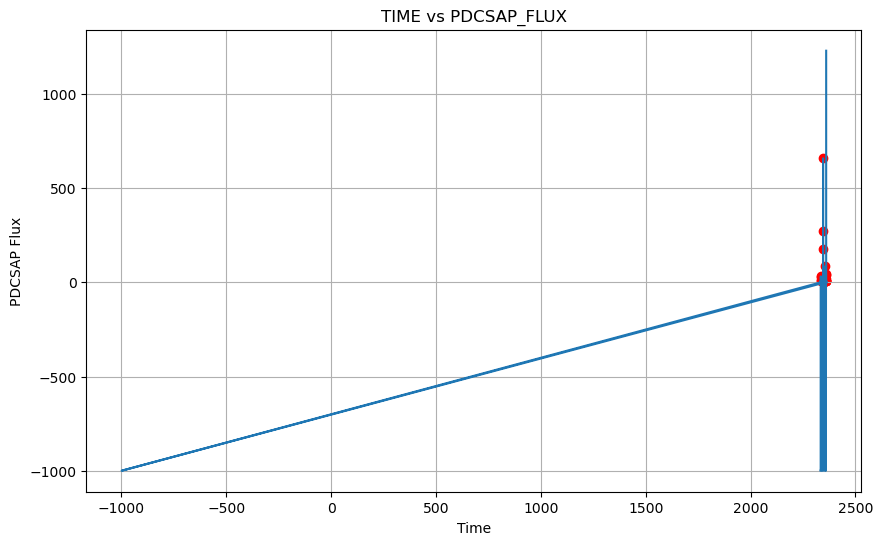

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(t1[BHindex1], LC_FLUX_mod['DE-HARMONIC'][start+BHindex1], color='red')
plt.scatter(t2[BHindex2], LC_FLUX_mod['DE-HARMONIC'][end_index+1+BHindex2], color='red')
plt.plot(LC_FLUX_mod['TIME'], LC_FLUX_mod['DE-HARMONIC'], label='PDCSAP_FLUX')

plt.xlabel('Time')
plt.ylabel('PDCSAP Flux')
plt.title('TIME vs PDCSAP_FLUX')
#plt.legend()
plt.grid(True)


plt.show()

In [35]:
import matplotlib.pyplot as plt

# Ensure 'Zt' and 'FLARE_UNION' columns exist in LC_FLUX_mod
if 'Zt' in LC_FLUX_mod.columns and 'FLARE_UNION' in LC_FLUX_mod.columns:
    plt.figure(figsize=(12, 6))
    
    # Plot 'Zt' as a line plot
    plt.plot(LC_FLUX_mod.index, LC_FLUX_mod['Zt'], label='Zt', color='blue', linestyle='-')
    
    # Filter indices where 'FLARE_UNION' == 1
    flare_indices = LC_FLUX_mod.index[LC_FLUX_mod['FLARE_UNION'] == 1]
    flare_values = LC_FLUX_mod['Zt'][LC_FLUX_mod['FLARE_UNION'] == 1]
    
    # Plot 'Zt' values where 'FLARE_UNION' == 1 as a scatter plot
    plt.scatter(flare_indices, flare_values, color='red', label='Flares (FLARE_UNION=1)', marker='o')
    
    # Labeling the plot
    plt.xlabel("Index")
    plt.ylabel("Zt Values")
    plt.title("Zt with Flares Marked (FLARE_UNION=1)")
    plt.legend()
    
    # Show the plot
    plt.show()
else:
    print("One or both of the columns 'Zt' and 'FLARE_UNION' do not exist in LC_FLUX_mod.")


One or both of the columns 'Zt' and 'FLARE_UNION' do not exist in LC_FLUX_mod.


In [36]:
import matplotlib.pyplot as plt

# Ensure 'DE-HARMONIC' and 'FLARE_UNION' columns exist in LC_FLUX_mod
if 'DE-HARMONIC' in LC_FLUX_mod.columns and 'FLARE_UNION' in LC_FLUX_mod.columns:
    plt.figure(figsize=(12, 6))
    
    # Plot 'DE-HARMONIC' as a line plot
    plt.plot(LC_FLUX_mod.index, LC_FLUX_mod['DE-HARMONIC'], label='DE-HARMONIC', color='blue', linestyle='-')
    
    # Filter indices where 'FLARE_UNION' == 1
    flare_indices = LC_FLUX_mod.index[LC_FLUX_mod['FLARE_UNION'] == 1]
    flare_values = LC_FLUX_mod['DE-HARMONIC'][LC_FLUX_mod['FLARE_UNION'] == 1]
    
    # Plot 'DE-HARMONIC' values where 'FLARE_UNION' == 1 as a scatter plot
    plt.scatter(flare_indices, flare_values, color='red', label='Flares (FLARE_UNION=1)', marker='o')
    
    # Labeling the plot
    plt.xlabel("Index")
    plt.ylabel("DE-HARMONIC Values")
    plt.title("DE-HARMONIC with Flares Marked (FLARE_UNION=1)")
    plt.legend()
    
    # Show the plot
    plt.show()
else:
    print("One or both of the columns 'DE-HARMONIC' and 'FLARE_UNION' do not exist in LC_FLUX_mod.")


One or both of the columns 'DE-HARMONIC' and 'FLARE_UNION' do not exist in LC_FLUX_mod.


In [37]:
def bootstrap_fit(model, params, x, y, n_bootstraps):
    """
    Perform bootstrap resampling to estimate parameter standard errors.

    Parameters:
    - model: lmfit Model object.
    - params: lmfit Parameters object with initial parameter values.
    - x: Independent variable data (e.g., time).
    - y: Dependent variable data (e.g., observed values).
    - n_bootstraps: Number of bootstrap samples.

    Returns:
    - bootstrap_params: List of dictionaries containing parameter estimates from each bootstrap sample.
    """
    bootstrap_params = []

    n_data = len(y)
    indices = np.arange(n_data)

    for i in range(n_bootstraps):
        # Resample indices with replacement
        resample_indices = np.random.choice(indices, size=n_data, replace=True)

        # Resample data
        x_resampled = x[resample_indices]
        y_resampled = y[resample_indices]

        # Fit the model to the resampled data
        # Create a copy of the parameters for each fit
        params_copy = params.copy()
        result = model.fit(y_resampled, params_copy, t=x_resampled)

        # Extract parameter values and store them
        param_values = {name: result.params[name].value for name in result.params}
        bootstrap_params.append(param_values)

        # Optional: Print progress
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{n_bootstraps} bootstrap iterations.")

    return bootstrap_params



In [38]:
# Number of bootstrap samples
#n_bootstraps = 100  # Increase this number for more accurate estimates

# Your observed data (replace with your actual data)
# Assuming ts_object is your observed data and time is your independent variable


# Run bootstrap fitting
#bootstrap_results = bootstrap_fit(model_1, params_1, t1, y1.copy(), n_bootstraps)


In [39]:
# Number of bootstrap samples
#n_bootstraps = 100  # Increase this number for more accurate estimates

# Your observed data (replace with your actual data)
# Assuming ts_object is your observed data and time is your independent variable


# Run bootstrap fitting
#bootstrap_results_2 = bootstrap_fit(model_2, params_2, t2, y2.copy(), n_bootstraps)


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming bootstrap_results is your list of dictionaries from the bootstrap fitting
# Convert the list of dictionaries to a DataFrame
#bootstrap_df = pd.DataFrame(bootstrap_results)

# Calculate mean and standard error for each parameter
#param_stats = bootstrap_df.agg(['mean', 'std']).transpose()
#param_stats.rename(columns={'std': 'stderr'}, inplace=True)

# Display the parameter estimates and standard errors
#print("Parameter Estimates and Bootstrap Standard Errors:")
#print(param_stats)

# Access the standard error of a specific parameter
#beta_0_stderr = param_stats.loc['beta_0', 'stderr']
#print(f"Standard error of beta_0: {beta_0_stderr}")

# Optional: Save the parameter statistics to a CSV file
#param_stats.to_csv('bootstrap_parameter_estimates.csv')

# Optional: Plot histogram for a specific parameter
#param_name = 'beta_0'
#plt.hist(bootstrap_df[param_name], bins=30, edgecolor='black')
#plt.title(f"Bootstrap Distribution of {param_name}")
#plt.xlabel(param_name)
#plt.ylabel("Frequency")
#plt.show()

# Optional: Calculate 95% confidence interval for a parameter
#ci_lower = bootstrap_df[param_name].quantile(0.025)
#ci_upper = bootstrap_df[param_name].quantile(0.975)
#print(f"95% Confidence Interval for {param_name}: ({ci_lower}, {ci_upper})")
